In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os
from tqdm import tqdm
from google.colab import files

import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Activation, LeakyReLU,
    AveragePooling2D, Multiply
)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [3]:
IMG_SIZE = 128
BASE_DIR = '/content/drive/MyDrive/CattleImageRepository'

def load_and_preprocess_data(base_dir, subdirs):
    X, y = [], []

    x_dirs = ['X', 'x1_files', 'x2_files', 'x3_files', 'x4_files', 'X']
    y_dirs = ['Y', 'y1_files', 'y2_files', 'y3_files', 'y4_files', 'y']

    for subdir in subdirs:

        counter = 0

        full_path = os.path.join(base_dir, *subdir.split('/'))

        x_dir, y_dir = None, None

        for x_subdir, y_subdir in zip(x_dirs, y_dirs):
            test_x_dir = os.path.join(full_path, x_subdir)
            test_y_dir = os.path.join(full_path, y_subdir)
            if os.path.isdir(test_x_dir) and os.path.isdir(test_y_dir):
                x_dir, y_dir = test_x_dir, test_y_dir
                break

        if x_dir and y_dir:
            x_files = [f for f in os.listdir(x_dir) if f.endswith(('x.png', 'x1.png', 'x.jpeg', 'x1.jpeg'))]

            for x_file in x_files:
                y_file = x_file.replace('x.', 'y.').replace('x1.', 'y1.')
                y_path = os.path.join(y_dir, y_file)
                if os.path.exists(y_path):
                    x_path = os.path.join(x_dir, x_file)
                    img = cv2.imread(x_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    X.append(img)

                    mask = cv2.imread(y_path)
                    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
                    y.append(mask)

                    counter += 1

            print(f"{subdir}: {counter} imagens processadas.")
        else:
            print(f"Erro: Pastas 'X' ou 'Y/y' não encontradas em {subdir}")

    return np.array(X), np.array(y)

subdirs = [
    'G1/01-08-2024', 'G1/08-08-2024',
    'G2/29-07/00000000196000500', 'G2/29-07/00000000196000400',
    'G2/06-08/Video_1', 'G2/06-08/Video_2',
    'G3/30-07/termica', 'G4/02-08'
]

X, y = load_and_preprocess_data(BASE_DIR, subdirs)
X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

G1/01-08-2024: 579 imagens processadas.
G1/08-08-2024: 613 imagens processadas.
G2/29-07/00000000196000500: 218 imagens processadas.
G2/29-07/00000000196000400: 268 imagens processadas.
G2/06-08/Video_1: 771 imagens processadas.
G2/06-08/Video_2: 63 imagens processadas.
G3/30-07/termica: 607 imagens processadas.
G4/02-08: 830 imagens processadas.


In [3]:
!pip install h5py

In [5]:
HDF5_FILE = '/content/drive/MyDrive/CattleImageRepository/labels.h5'

with h5py.File(HDF5_FILE, 'w') as hf:
    hf.create_dataset('X_save_2108', data=X, compression='gzip', compression_opts=9)
    hf.create_dataset('y_save_2108', data=y, compression='gzip', compression_opts=9)

print(f'Dados salvos no arquivo HDF5 em {HDF5_FILE}')

Dados salvos no arquivo HDF5 em /content/drive/MyDrive/CattleImageRepository/labels.h5


In [4]:
HDF5_FILE = '/content/drive/MyDrive/CattleImageRepository/labels.h5'

files.download(HDF5_FILE)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
HDF5_FILE = '/content/drive/MyDrive/CattleImageRepository/labels.h5'

with h5py.File(HDF5_FILE, 'r') as hf:

    X = hf['X_save_2108'][:]
    y = hf['y_save_2108'][:]

X.shape, y.shape

((3949, 128, 128, 3, 1), (3949, 128, 128, 3, 1))

(128, 128, 3)


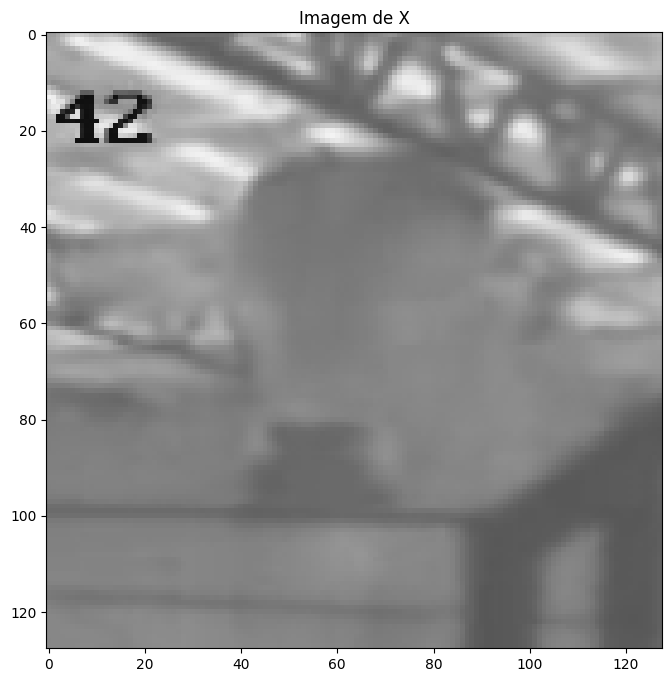

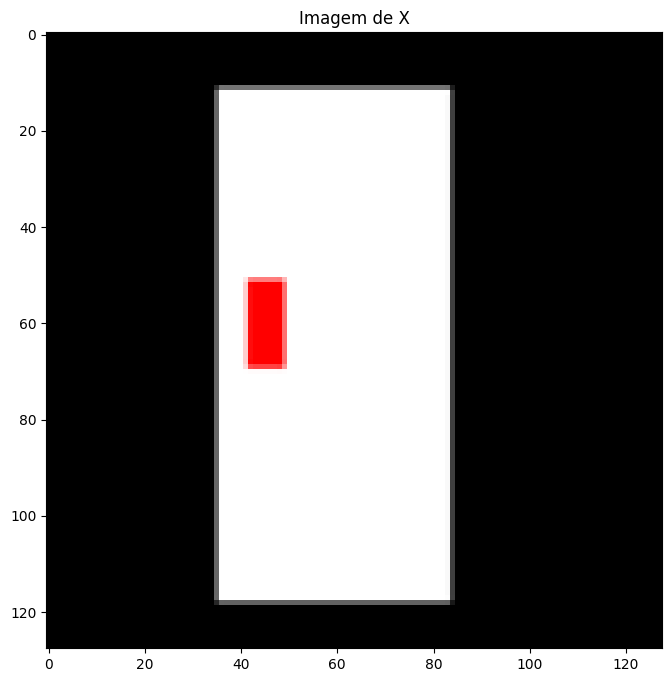

In [9]:
image = X[np.random.randint(0, X.shape[0])]
image2= y[np.random.randint(0, y.shape[0])]

if image.shape[-1] == 1:
    image = image.squeeze()

if image2.shape[-1] == 1:
    image2 = image2.squeeze()

print(image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Imagem de X')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Imagem de X')
plt.show()

In [10]:
X.shape, y.shape

((3949, 128, 128, 3, 1), (3949, 128, 128, 3, 1))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [12]:
X_train.shape, y_train.shape

((3159, 128, 128, 3, 1), (3159, 128, 128, 3, 1))

In [13]:
X_test.shape, y_test.shape

((790, 128, 128, 3, 1), (790, 128, 128, 3, 1))

In [14]:
def apply_data_augmentation(X, y, variations=2):

    X_augmented = []
    y_augmented = []

    datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.8, 1.2],
        channel_shift_range=50,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    for i in range(X.shape[0]):

        image = X[i]
        mask = y[i]

        if image.ndim == 4:
            image = image.squeeze()
        if mask.ndim == 4:
            mask = mask.squeeze()

        X_augmented.append(image)
        y_augmented.append(mask)

        for j in range(variations):
            params = datagen.get_random_transform(image.shape)

            augmented_image = datagen.apply_transform(image, params)
            augmented_mask = datagen.apply_transform(mask, params)

            X_augmented.append(augmented_image)
            y_augmented.append(augmented_mask)

    return np.array(X_augmented), np.array(y_augmented)

X_train_augmented, y_train_augmented = apply_data_augmentation(X_train, y_train)

In [15]:
X_train_augmented = X_train_augmented / 255.0
y_train_augmented = y_train_augmented / 255.0

X_test = X_test.squeeze() / 255.0
y_test = y_test.squeeze() / 255.0

In [16]:
X_train_augmented.shape, y_train_augmented.shape

((9477, 128, 128, 3), (9477, 128, 128, 3))

In [17]:
X_test.shape, y_test.shape

((790, 128, 128, 3), (790, 128, 128, 3))

(-0.5, 127.5, 127.5, -0.5)

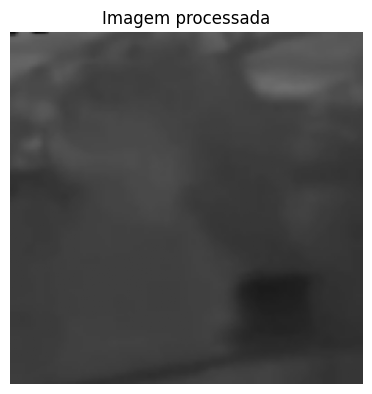

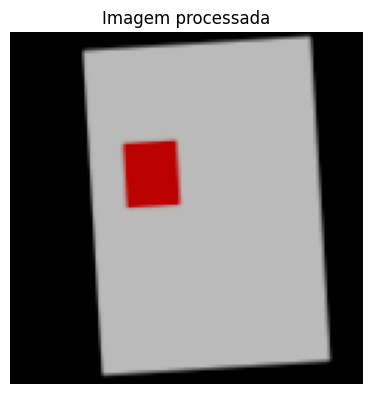

In [18]:
index = np.random.randint(0, X_train_augmented.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

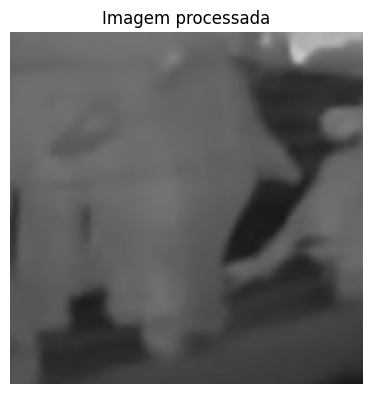

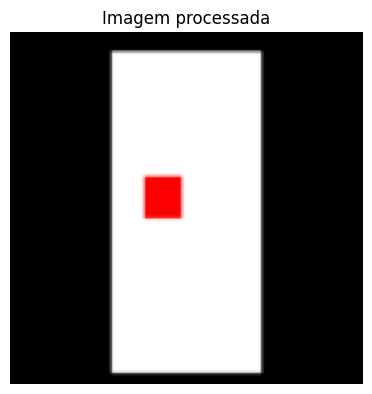

In [19]:
index = np.random.randint(0, X_test.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_test[index])
plt.title("Imagem processada")
plt.axis('off')

In [20]:
def reduce_colors(img_array, colors):

    assert img_array.shape == (128, 128, 3), "Input array must have shape (128, 128, 3)"

    fixed_colors = np.array(colors)
    pixels = img_array.reshape(-1, 3)
    distances = np.sqrt(((pixels[:, np.newaxis, :] - fixed_colors) ** 2).sum(axis=2))
    nearest_color_indices = distances.argmin(axis=1)
    new_img = fixed_colors[nearest_color_indices].reshape(img_array.shape)

    return (new_img * 255).astype('uint8')

def reduce_colors_dataset(dataset, colors):
    return np.array([reduce_colors(img, colors) for img in tqdm(dataset, desc="Processing images")])

In [21]:
colors = [
    (1.0, 1.0, 1.0),
    (1.0, 0.0, 0.0),
    (0.0, 0.0, 0.0)
]

y_train_reduced = reduce_colors_dataset(y_train_augmented, colors)
y_test_reduced = reduce_colors_dataset(y_test, colors)

Processing images: 100%|██████████| 790/790 [00:01<00:00, 403.48it/s]


In [22]:
def process_images(X_train, X_test):

    def apply_clahe(image):
        image_gray = (image * 255).astype(np.uint8)
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(2, 2))
        image_clahe = clahe.apply(image_gray)
        image_clahe_rgb = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        return image_clahe_rgb / 255.0

    def adjust_contrast(image, factor):
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        enhancer = ImageEnhance.Contrast(image_pil)
        image_pil = enhancer.enhance(factor)
        return np.array(image_pil) / 255.0

    def process_single_image(image):
        clahe_image = apply_clahe(image)
        adjusted_image = adjust_contrast(clahe_image, 1.5)
        return adjusted_image

    X_train_processed = np.array([process_single_image(img) for img in X_train])
    X_test_processed = np.array([process_single_image(img) for img in X_test])

    return X_train_processed, X_test_processed

In [23]:
X_train_processed, X_test_processed = process_images(X_train_augmented.copy(), X_test.copy())

In [24]:
min_samples = min(X_train.shape[0], y_train.shape[0])

val_split = 0.2
val_samples = int(min_samples * val_split)
X_val = X_train_processed[-val_samples:]
y_val = y_train_reduced[-val_samples:]
X_train = X_train_processed[:-val_samples]
y_train = y_train_reduced[:-val_samples]

In [25]:
X_train.shape, y_train.shape

((8846, 128, 128, 3), (8846, 128, 128, 3))

In [26]:
X_val.shape, y_val.shape

((631, 128, 128, 3), (631, 128, 128, 3))

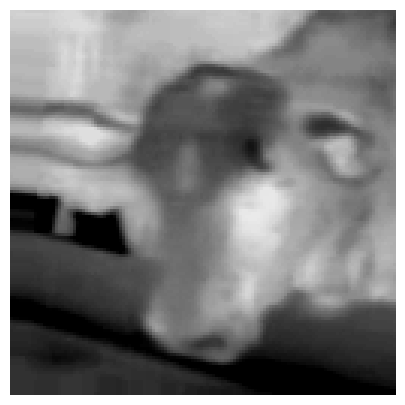

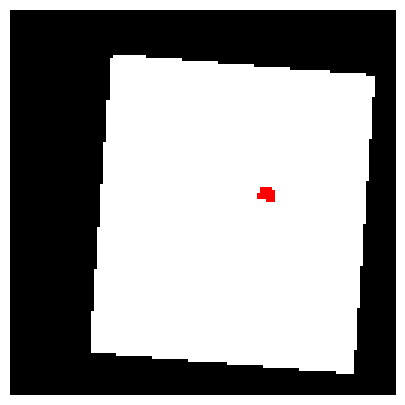

In [27]:
index_random = np.random.randint(0, X_train.shape[0])

plt.figure(figsize=(10, 5))
plt.imshow(X_train[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

plt.figure(figsize=(10, 5))
plt.imshow(y_train[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

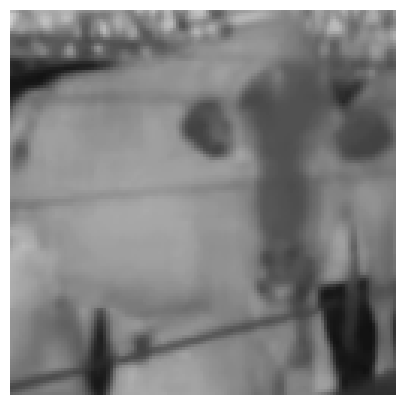

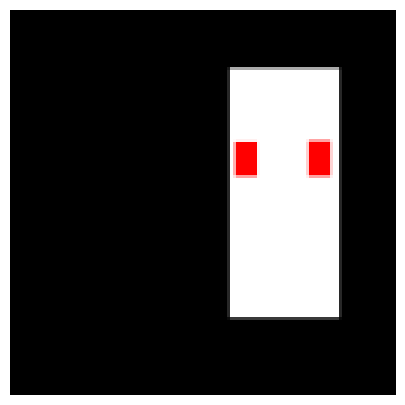

In [28]:
index_random = np.random.randint(0, X_test.shape[0])

plt.figure(figsize=(10, 5))
plt.imshow(X_test[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

plt.figure(figsize=(10, 5))
plt.imshow(y_test[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

In [31]:
vgg16_path = '/content/drive/MyDrive/VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5'

try:
    vgg16 = load_model(vgg16_path, compile=False)
    print("VGG16 model loaded successfully")
except Exception as e:
    print(f"Error loading VGG16 model: {e}")
    raise

VGG16 model loaded successfully


In [70]:
def simple_segmentation_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
        return 1 - dice

    def binary_crossentropy(y_true, y_pred):
        return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Combine Dice Loss and Binary Cross-Entropy
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * binary_crossentropy(y_true, y_pred)

# Load the VGG16 model
vgg16_path = '/content/drive/MyDrive/VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5'
try:
    vgg16 = load_model(vgg16_path, compile=False)
    print("VGG16 model loaded successfully")
    print("VGG16 input shape:", vgg16.input_shape)
    print("VGG16 output shape:", vgg16.output_shape)
except Exception as e:
    print(f"Error loading VGG16 model: {e}")
    raise

def simplified_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    vgg16 = load_model(vgg16_path, compile=False)

    # Encoder (use VGG16 layers)
    x = vgg16.get_layer('block1_conv1')(inputs)
    x = vgg16.get_layer('block1_conv2')(x)
    skip1 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block2_conv1')(x)
    x = vgg16.get_layer('block2_conv2')(x)
    skip2 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block3_conv1')(x)
    x = vgg16.get_layer('block3_conv2')(x)
    x = vgg16.get_layer('block3_conv3')(x)
    skip3 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block4_conv1')(x)
    x = vgg16.get_layer('block4_conv2')(x)
    x = vgg16.get_layer('block4_conv3')(x)
    skip4 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block5_conv1')(x)
    x = vgg16.get_layer('block5_conv2')(x)
    x = vgg16.get_layer('block5_conv3')(x)

    # Decoder
    x = UpSampling2D()(x)
    x = concatenate([x, skip4])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip3])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip2])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip1])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)

    outputs = Conv2D(3, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = simplified_unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=simple_segmentation_loss,
              metrics=['accuracy'])

model.summary()

# Verify and preprocess data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('unet_boi_olhos_vgg16_v1.2.keras', save_best_only=True, monitor='val_loss')
    ]
)

model.save('unet_boi_olhos_vgg16_v1.2.h5')
print("Model saved successfully")

VGG16 model loaded successfully
VGG16 input shape: (None, 128, 128, 3)
VGG16 output shape: (None, 128, 128, 3)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ block1_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 128)    │              0 │ block2_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 16, 16, 256)    │              0 │ block3_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 8, 8, 512)      │              0 │ block4_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[1][0]     │
├──────────────────────

 Total params: 24,891,267 (94.95 MB)

 Trainable params: 24,891,267 (94.95 MB)

 Non-trainable params: 0 (0.00 B)

X_train shape: (8846, 128, 128, 3)
y_train shape: (8846, 128, 128, 3)
Epoch 1/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.4210 - loss: 33.6884 - val_accuracy: 0.7493 - val_loss: 32.4688 - learning_rate: 1.0000e-04
Epoch 2/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.7567 - loss: 31.2624 - val_accuracy: 0.9769 - val_loss: 31.9142 - learning_rate: 1.0000e-04
Epoch 3/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9580 - loss: 31.1712 - val_accuracy: 0.9455 - val_loss: 31.8561 - learning_rate: 1.0000e-04
Epoch 4/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.9525 - loss: 30.5652 - val_accuracy: 0.9846 - val_loss: 31.7879 - learning_rate: 1.0000e-04
Epoch 5/5
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.9636 - loss: 30.0766 - val_accuracy: 0.9772 - val_loss: 31.8480 - learning_rate: 1.0000e-04


Model saved successfully


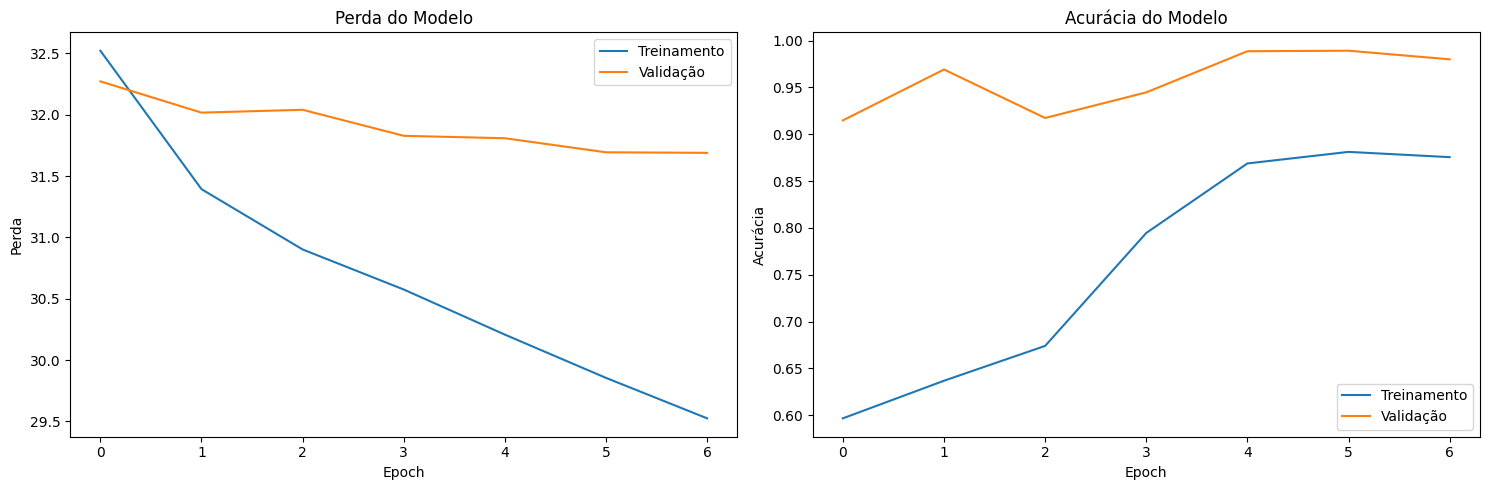

In [88]:
def plot_training_history(history):

    metrics = ['loss', 'accuracy']
    if 'val_loss' in history.history:
        metrics.extend(['val_loss', 'val_accuracy'])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        axs[0].plot(history.history['val_loss'], label='Validação')
    axs[0].set_title('Perda do Modelo')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perda')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Treinamento')
    if 'val_accuracy' in history.history:
        axs[1].plot(history.history['val_accuracy'], label='Validação')
    axs[1].set_title('Acurácia do Modelo')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [91]:
y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


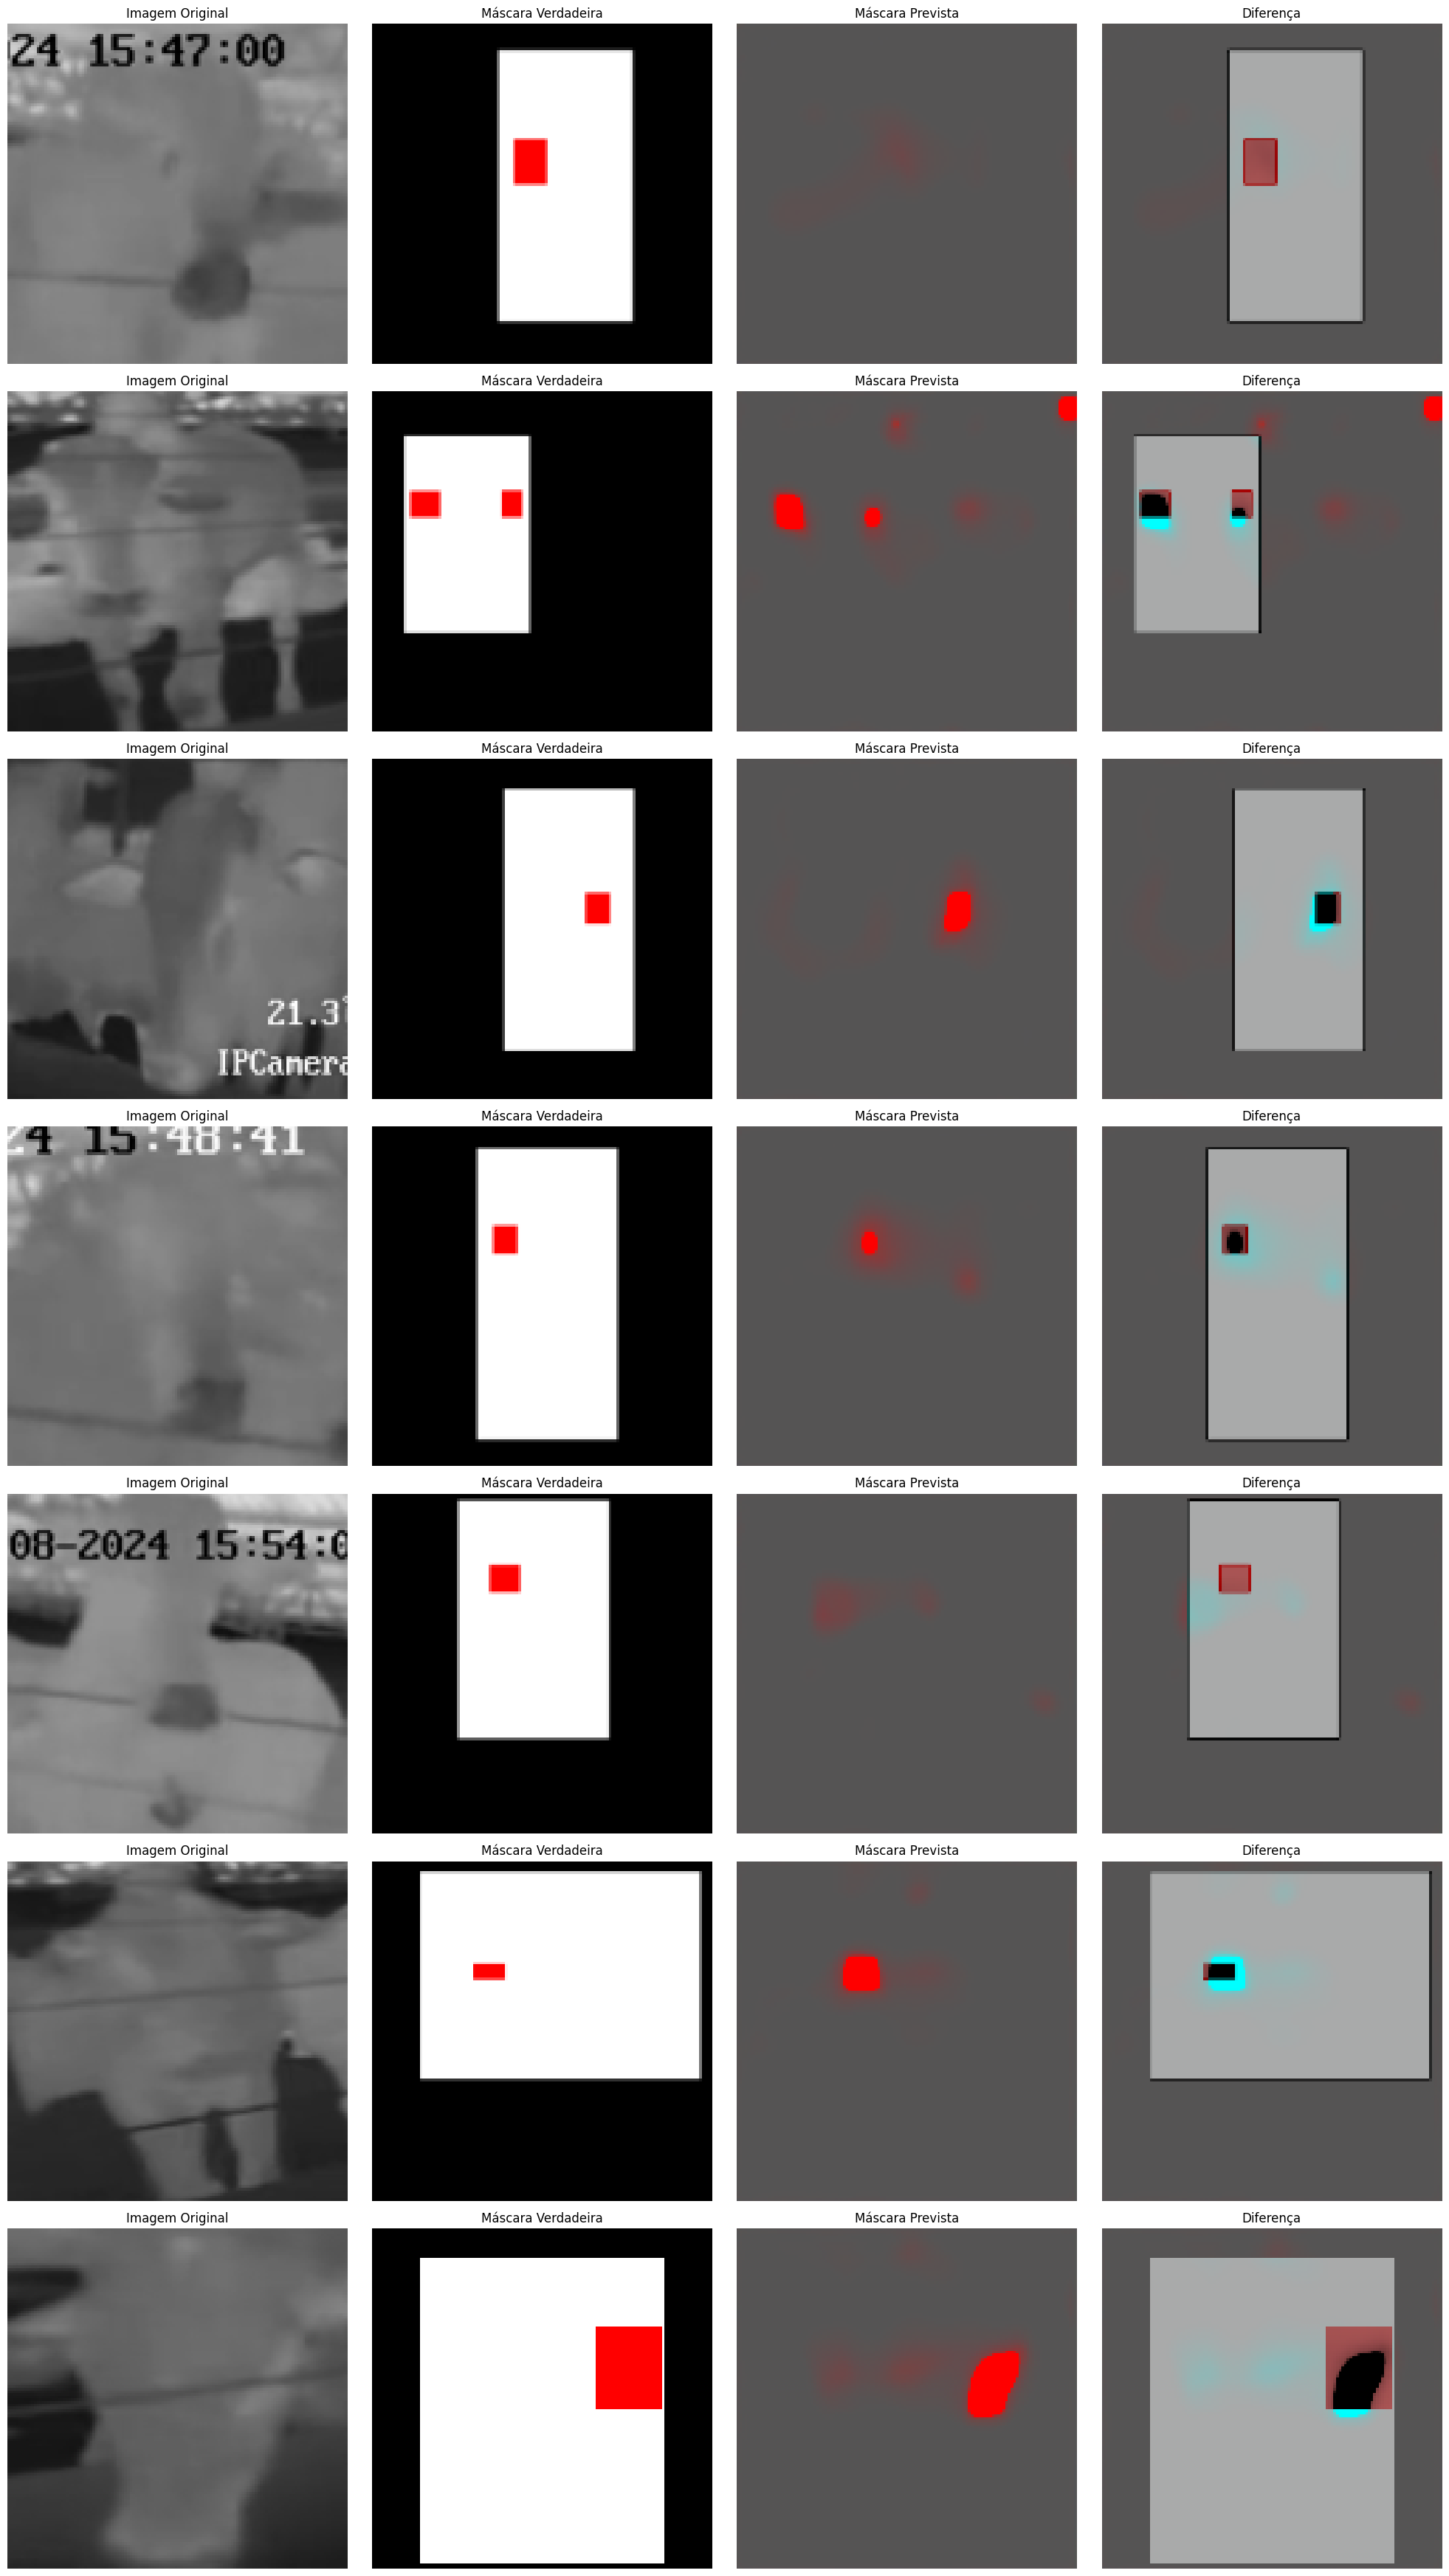

In [92]:
def visualize_results(X, y_true, y_pred, num_samples=7):

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):

        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(X_test, y_test, y_pred)

In [74]:
from google.colab import files

files.download('unet_boi_olhos_vgg16_v1.2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
'''
PDAtt-UNet: U-Net com Atenção e Decodificador Duplo Piramidal
----------------------------------------------------------------

Visão Geral da Arquitetura:

    Entrada
      |
      v
    [Codificador VGG16]
      |
      v
    [Módulo de Pooling Piramidal]
      |
      v
    [Decodificador Duplo com Portões de Atenção]
      |
      v
    [Fusão de Saída]

Componentes Principais:

a) Codificador VGG16:
   - Extração de características hierárquicas com transfer learning.

b) Módulo de Pooling Piramidal (MPP):
   - Mitiga a perda de informação espacial.
   - Formulação: MPP(x) = Concat[x, Pool_1(x), Pool_2(x), ..., Pool_n(x)]
   - Cada Pool_i inclui: PoolingGlobal -> Conv1x1 -> Upsampling

c) Portão de Atenção (PA):
   - Permite foco em características salientes.
   - PA(x, g) = σ(W_x * x + W_g * g + b_g) * x
   - Onde x: conexão skip, g: sinal de gate, σ: ativação sigmoide

d) Decodificador Duplo:
   - Caminhos de decodificação paralelos com conexões skip compartilhadas.
   - D_i = UpSample(Conv(PA(skip_i, D_{i-1})))

e) Fusão de Saída:
   - Adição elemento a elemento das saídas do decodificador.
   - O = Conv(D1 + D2)

Vantagens Teóricas:
- Representação de características multi-escala aprimorada via MPP.
- Fluxo de gradiente melhorado através de mecanismos de atenção.
- Maior capacidade do modelo e robustez através da decodificação dupla.
'''

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Multiply, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def attention_gate(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, 1, use_bias=False)(x)
    phi_g = Conv2D(inter_channel, 1, use_bias=False)(g)

    f = Multiply()([theta_x, phi_g])
    f = Conv2D(1, 1, activation='sigmoid')(f)

    y = Multiply()([x, f])
    return y

def pyramid_pooling_module(x, num_filters):
    _, h, w, _ = K.int_shape(x)
    pool_sizes = [1, 2, 3, 6]
    pooled_features = []

    for pool_size in pool_sizes:
        pool_size = min(pool_size, h, w)
        pooled = AveragePooling2D(pool_size=(pool_size, pool_size))(x)
        pooled = Conv2D(num_filters, 1, activation='relu')(pooled)
        pooled = UpSampling2D(size=(h // K.int_shape(pooled)[1], w // K.int_shape(pooled)[2]), interpolation='bilinear')(pooled)
        pooled_features.append(pooled)

    return concatenate([x] + pooled_features)

def simple_segmentation_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
        return 1 - dice

    def binary_crossentropy(y_true, y_pred):
        return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * binary_crossentropy(y_true, y_pred)

def pdatt_unet(input_size=(128, 128, 3), vgg16_path='path_to_vgg16_weights.h5'):
    inputs = Input(input_size)

    vgg16_path = '/content/drive/MyDrive/VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5'

    vgg16 = load_model(vgg16_path, compile=False)

    # Encoder (VGG16)
    x = vgg16.get_layer('block1_conv1')(inputs)
    x = vgg16.get_layer('block1_conv2')(x)
    skip1 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block2_conv1')(x)
    x = vgg16.get_layer('block2_conv2')(x)
    skip2 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block3_conv1')(x)
    x = vgg16.get_layer('block3_conv2')(x)
    x = vgg16.get_layer('block3_conv3')(x)
    skip3 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block4_conv1')(x)
    x = vgg16.get_layer('block4_conv2')(x)
    x = vgg16.get_layer('block4_conv3')(x)
    skip4 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block5_conv1')(x)
    x = vgg16.get_layer('block5_conv2')(x)
    x = vgg16.get_layer('block5_conv3')(x)

    # Pyramid Pooling Module
    x = pyramid_pooling_module(x, 256)

    # Decoder 1
    x1 = UpSampling2D()(x)
    x1 = concatenate([x1, attention_gate(skip4, x1, 256)])
    x1 = Conv2D(512, 3, activation='relu', padding='same')(x1)
    x1 = Conv2D(512, 3, activation='relu', padding='same')(x1)
    x1 = Dropout(0.3)(x1)

    x1 = UpSampling2D()(x1)
    x1 = concatenate([x1, attention_gate(skip3, x1, 128)])
    x1 = Conv2D(256, 3, activation='relu', padding='same')(x1)
    x1 = Conv2D(256, 3, activation='relu', padding='same')(x1)
    x1 = Dropout(0.3)(x1)

    x1 = UpSampling2D()(x1)
    x1 = concatenate([x1, attention_gate(skip2, x1, 64)])
    x1 = Conv2D(128, 3, activation='relu', padding='same')(x1)
    x1 = Conv2D(128, 3, activation='relu', padding='same')(x1)
    x1 = Dropout(0.2)(x1)

    x1 = UpSampling2D()(x1)
    x1 = concatenate([x1, attention_gate(skip1, x1, 32)])
    x1 = Conv2D(64, 3, activation='relu', padding='same')(x1)
    x1 = Conv2D(64, 3, activation='relu', padding='same')(x1)
    x1 = Dropout(0.1)(x1)

    # Decoder 2
    x2 = UpSampling2D()(x)
    x2 = concatenate([x2, attention_gate(skip4, x2, 256)])
    x2 = Conv2D(512, 3, activation='relu', padding='same')(x2)
    x2 = Conv2D(512, 3, activation='relu', padding='same')(x2)
    x2 = Dropout(0.3)(x2)

    x2 = UpSampling2D()(x2)
    x2 = concatenate([x2, attention_gate(skip3, x2, 128)])
    x2 = Conv2D(256, 3, activation='relu', padding='same')(x2)
    x2 = Conv2D(256, 3, activation='relu', padding='same')(x2)
    x2 = Dropout(0.3)(x2)

    x2 = UpSampling2D()(x2)
    x2 = concatenate([x2, attention_gate(skip2, x2, 64)])
    x2 = Conv2D(128, 3, activation='relu', padding='same')(x2)
    x2 = Conv2D(128, 3, activation='relu', padding='same')(x2)
    x2 = Dropout(0.2)(x2)

    x2 = UpSampling2D()(x2)
    x2 = concatenate([x2, attention_gate(skip1, x2, 32)])
    x2 = Conv2D(64, 3, activation='relu', padding='same')(x2)
    x2 = Conv2D(64, 3, activation='relu', padding='same')(x2)
    x2 = Dropout(0.1)(x2)

    outputs = Add()([x1, x2])
    outputs = Conv2D(3, 1, activation='softmax')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = pdatt_unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=simple_segmentation_loss,
              metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=7,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('pdatt_unet_boi_olhos_vgg16_v1.0.keras', save_best_only=True, monitor='val_loss')
    ]
)

model.save('pdatt_unet_boi_olhos_vgg16_v1.0.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 64)     │              0 │ block1_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 32, 32, 128)    │              0 │ block2_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 16, 16, 256)    │              0 │ block3_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 8, 8, 512)      │              0 │ block4_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[1][0]     │
├──────────────────────

 Total params: 46,337,739 (176.76 MB)

 Trainable params: 46,337,739 (176.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
277/277 ━━━━━━━━━━━━━━━━━━━━ 106s 228ms/step - accuracy: 0.5623 - loss: 33.7484 - val_accuracy: 0.4805 - val_loss: 32.7283 - learning_rate: 1.0000e-04
Epoch 2/7
277/277 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.7378 - loss: 32.0642 - val_accuracy: 0.9688 - val_loss: 32.1773 - learning_rate: 1.0000e-04
Epoch 3/7
277/277 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.9492 - loss: 31.3518 - val_accuracy: 0.9808 - val_loss: 31.8904 - learning_rate: 1.0000e-04
Epoch 4/7
277/277 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.9766 - loss: 30.8190 - val_accuracy: 0.9958 - val_loss: 32.0062 - learning_rate: 1.0000e-04
Epoch 5/7
277/277 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.9844 - loss: 30.3220 - val_accuracy: 0.9851 - val_loss: 31.8667 - learning_rate: 1.0000e-04
Epoch 6/7
277/277 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.9883 - loss: 29.9749 - val_accuracy: 0.9960 - val_loss: 31.9184 - learning_rate: 1.0000e-04
Epoch 7/7
277/277 ━━━━━━━━━━━━━━━━━━━━ 

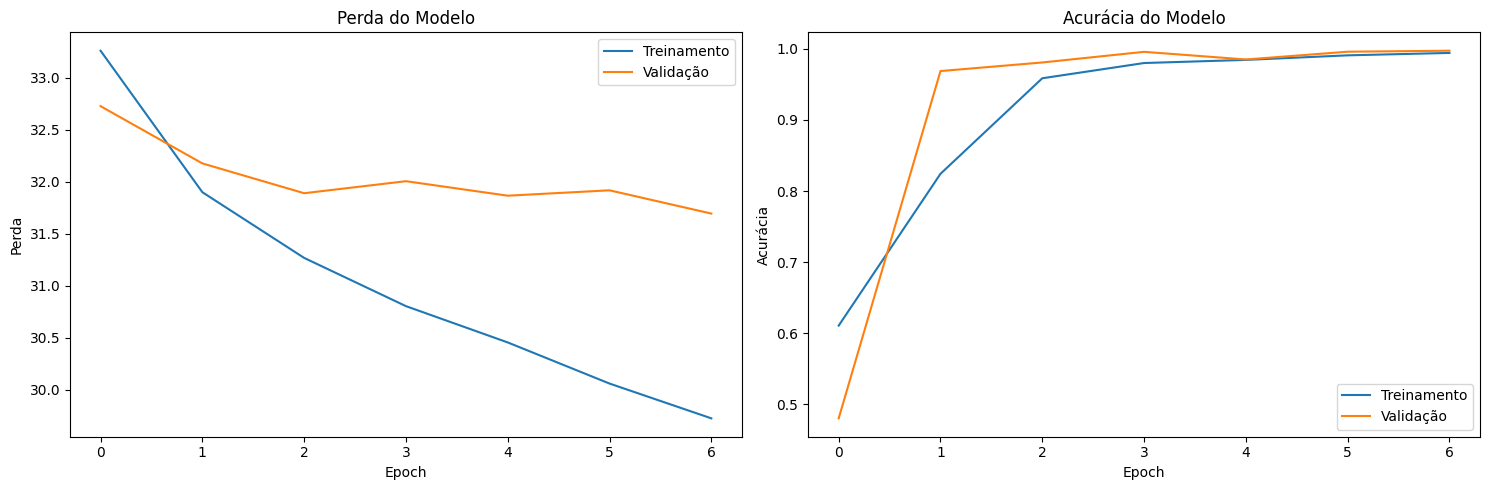

In [37]:
def plot_training_history(history):

    metrics = ['loss', 'accuracy']
    if 'val_loss' in history.history:
        metrics.extend(['val_loss', 'val_accuracy'])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        axs[0].plot(history.history['val_loss'], label='Validação')
    axs[0].set_title('Perda do Modelo')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perda')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Treinamento')
    if 'val_accuracy' in history.history:
        axs[1].plot(history.history['val_accuracy'], label='Validação')
    axs[1].set_title('Acurácia do Modelo')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step


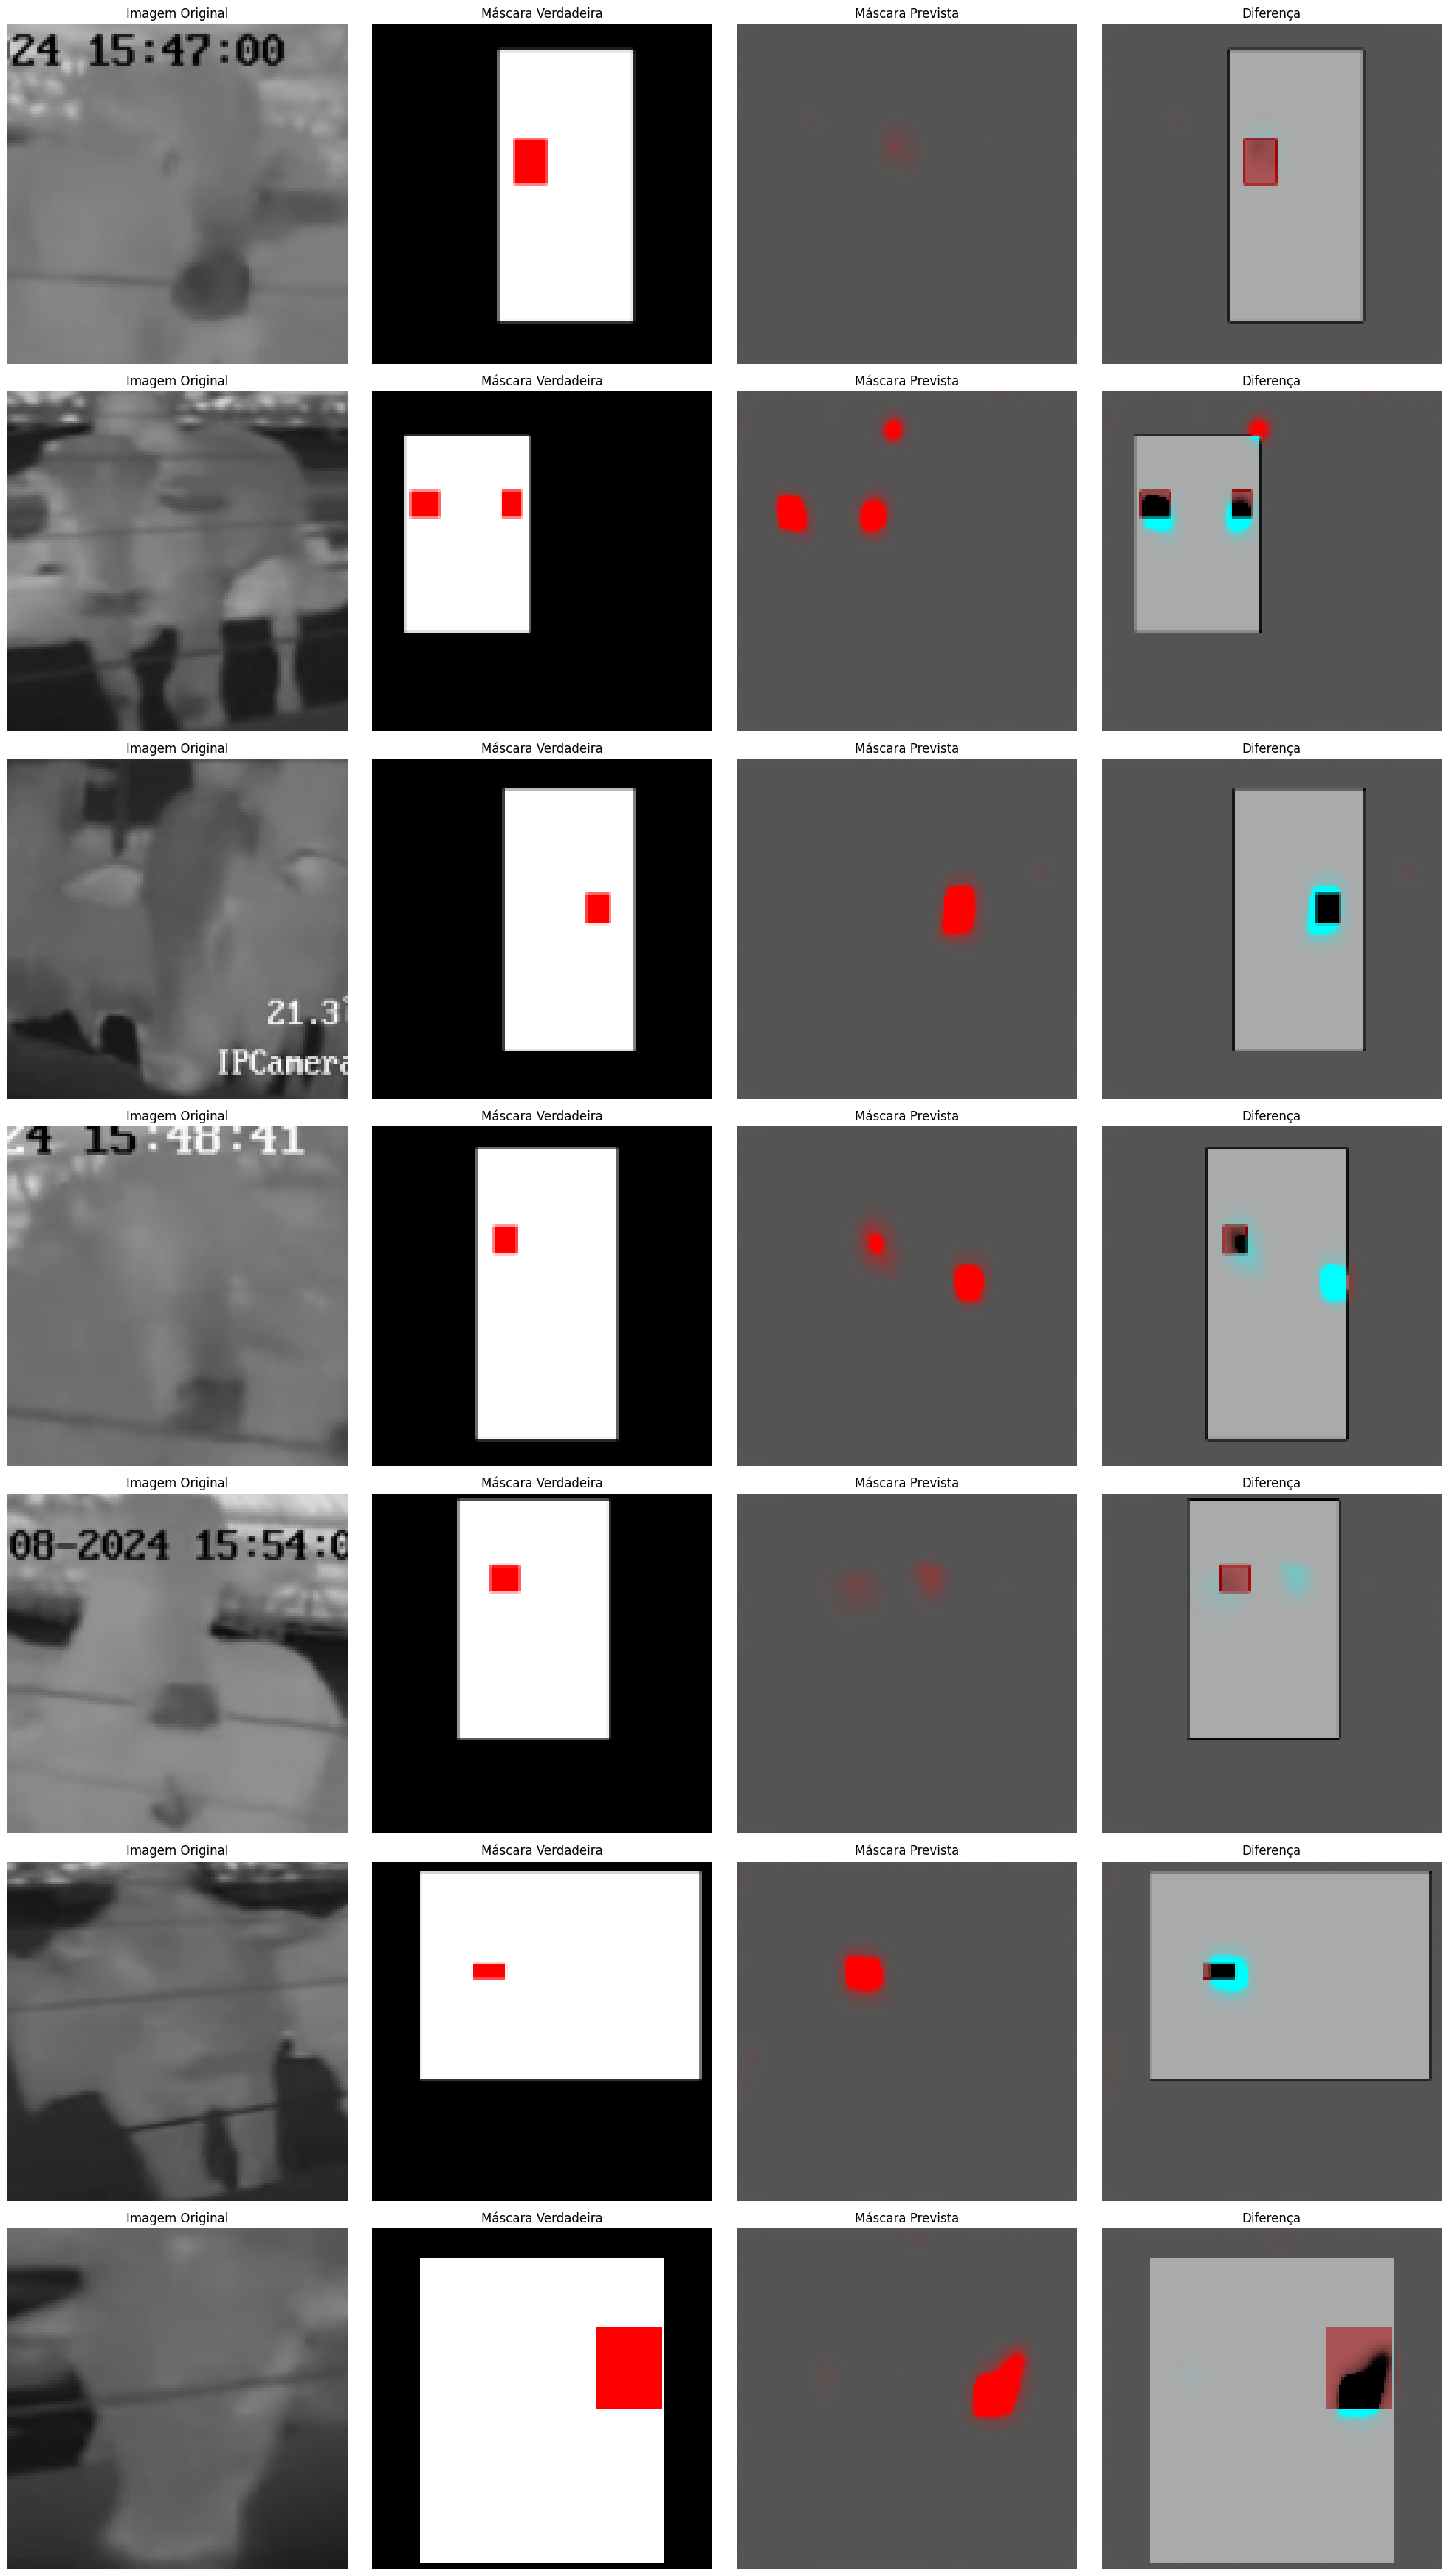

In [38]:
y_pred = model.predict(X_test)

def visualize_results(X, y_true, y_pred, num_samples=7):

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):

        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(X_test, y_test, y_pred)

In [39]:
from google.colab import files

files.download('pdatt_unet_boi_olhos_vgg16_v1.0.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>